<a href="https://colab.research.google.com/github/maxjlake96/football-xg-model/blob/main/Recreating_xG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# 0) Keep combined data in a distinct variable
shots_all = pd.concat([shots_wc18, shots_laliga, shots_wsl1718], ignore_index=True)
print("Combined rows:", len(shots_all))
assert len(shots_all) > 1000, "Your combined dataset is too small — did one of the sources fail?"

# 1) Feature engineering on the BIG dataframe (avoid fragmentation)
goal_x, goal_y = 120.0, 40.0

xy = shots_all["location"].apply(lambda loc: (loc[0], loc[1]) if isinstance(loc, list) else (np.nan, np.nan))
shots_all[["x","y"]] = pd.DataFrame(xy.tolist(), index=shots_all.index)

fe = pd.DataFrame({
    "shot_distance": np.sqrt((goal_x - shots_all["x"])**2 + (goal_y - shots_all["y"])**2),
    "shot_angle": np.abs(np.arctan2(44 - shots_all["y"], 120 - shots_all["x"])
                        - np.arctan2(36 - shots_all["y"], 120 - shots_all["x"])),
    "is_goal": (shots_all["shot_outcome_name"] == "Goal").astype(int),
    "is_penalty": (shots_all["shot_type_name"] == "Penalty").astype(int),
    "is_fk": (shots_all["shot_type_name"] == "Free Kick").astype(int),
}, index=shots_all.index)

shots_all = pd.concat([shots_all, fe], axis=1)
shots_all = shots_all.loc[:, ~shots_all.columns.duplicated()]  # nuke duped cols just in case

print("After FE rows:", len(shots_all))
print("Non-null feature counts:\n", shots_all[["shot_distance","shot_angle","is_goal","is_penalty","is_fk"]].notna().sum())

# 2) Build modeling frame (drop rows with missing x/y-derived features ONLY)
features = ["shot_distance","shot_angle","is_penalty","is_fk"]
df = shots_all.dropna(subset=features + ["is_goal"]).copy()

print("Modeling rows:", len(df), "Goals:", int(df["is_goal"].sum()))
assert len(df) > 1000, "Too few rows made it into the modeling frame — likely too many NaNs or wrong subset."

# 3) Train/test split with a *proper* test size
X = df[features].astype(float)
y = df["is_goal"].astype(int)

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train:", X_tr.shape, "Test:", X_te.shape, "| Goals in test:", int(y_te.sum()))

# Safety: if test is suspiciously tiny, stop early
assert X_te.shape[0] > 200, "Test set is tiny — something is still off (are you using shots_all?)."

# 4) Baseline model + AUC
clf = LogisticRegression(max_iter=2000)
clf.fit(X_tr, y_tr)
auc = roc_auc_score(y_te, clf.predict_proba(X_te)[:,1])
print(f"AUC (logreg, pens+FKs included): {auc:.3f}")

# 5) Optional: open-play only
mask_open = (df["is_penalty"]==0) & (df["is_fk"]==0)
X_open = df.loc[mask_open, features].astype(float)
y_open = df.loc[mask_open, "is_goal"].astype(int)

Xo_tr, Xo_te, yo_tr, yo_te = train_test_split(
    X_open, y_open, test_size=0.2, random_state=42, stratify=y_open
)
clf2 = LogisticRegression(max_iter=2000).fit(Xo_tr, yo_tr)
auc_open = roc_auc_score(yo_te, clf2.predict_proba(Xo_te)[:,1])
print(f"AUC (logreg, open-play only): {auc_open:.3f}")

# 6) (Better) Cross-validation for stability
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(LogisticRegression(max_iter=2000), X, y, cv=cv, scoring="roc_auc")
print(f"CV AUC mean: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


Combined rows: 4900
After FE rows: 4900
Non-null feature counts:
 shot_distance    4900
shot_angle       4900
is_goal          4900
is_penalty       4900
is_fk            4900
dtype: int64


/tmp/ipython-input-374467656.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

/tmp/ipython-input-374467656.py:16: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Modeling rows: 4900 Goals: 549
Train: (3920, 4) Test: (980, 4) | Goals in test: 110
AUC (logreg, pens+FKs included): 0.751
AUC (logreg, open-play only): 0.752
CV AUC mean: 0.768 ± 0.035


In [45]:
import pandas as pd

preds = pd.DataFrame({
    "xG_model": clf.predict_proba(X)[:,1]
}, index=shots_all.index)

shots_all = pd.concat([shots_all, preds], axis=1)


In [46]:
shots_all = shots_all.copy()


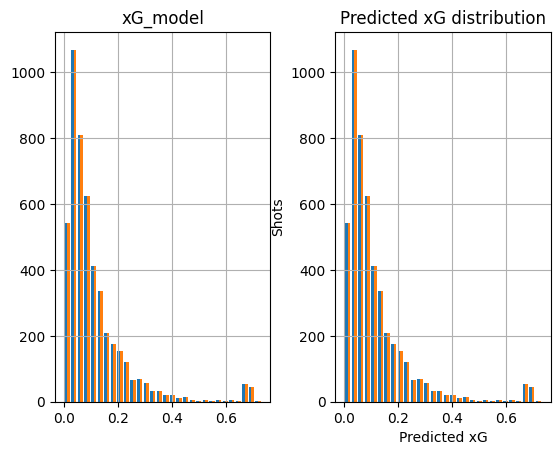

In [47]:
shots_all["xG_model"].hist(bins=30)
plt.xlabel("Predicted xG"); plt.ylabel("Shots"); plt.title("Predicted xG distribution")
plt.show()


AUC: 0.7670740432344133


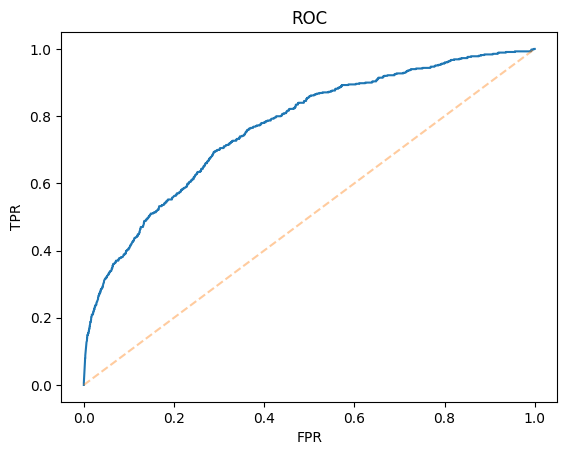

In [48]:
from sklearn.metrics import roc_auc_score, roc_curve
X = shots_all[["shot_distance","shot_angle","is_penalty","is_fk"]].fillna(0).astype(float)
y = (shots_all["shot_outcome_name"]=="Goal").astype(int)
p = clf.predict_proba(X)[:,1]
print("AUC:", roc_auc_score(y, p))

fpr, tpr, _ = roc_curve(y, p)
plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--',alpha=0.4)
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC"); plt.show()


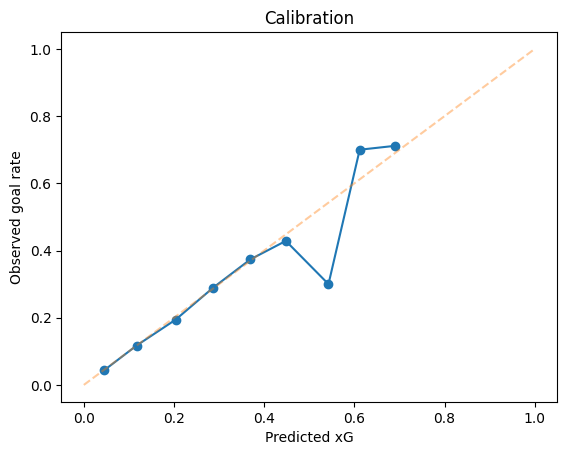

In [49]:
from sklearn.calibration import calibration_curve
prob_true, prob_pred = calibration_curve(y, p, n_bins=12)
plt.plot(prob_pred, prob_true, marker='o'); plt.plot([0,1],[0,1],'--',alpha=0.4)
plt.xlabel("Predicted xG"); plt.ylabel("Observed goal rate"); plt.title("Calibration"); plt.show()


In [50]:
player_summary = (shots_all
  .assign(is_goal=y, xG=p)
  .groupby("player_name", dropna=True)
  .agg(shots=("is_goal","count"), goals=("is_goal","sum"), xG=("xG","sum"))
  .assign(overperf=lambda d: d["goals"] - d["xG"])
  .sort_values("xG", ascending=False)
  .head(20))
player_summary


,shots,goals,xG,overperf
player_name,,,,
Lionel Andrés Messi Cuccittini,216,35,23.606098,11.393902
Luis Alberto Suárez Díaz,126,25,15.530794,9.469206
Bethany England,73,14,12.088249,1.911751
José Paulo Bezzera Maciel Júnior,49,10,8.107071,1.892929
Vivianne Miedema,57,16,7.277225,8.722775
Gerard Piqué Bernabéu,27,3,6.045486,-3.045486
Rianna Dean,27,4,6.029053,-2.029053
Pauline Bremer,46,10,5.840519,4.159481
Fara Williams,56,5,5.839117,-0.839117


In [51]:
team_summary = (shots_all
  .assign(is_goal=y, xG=p)
  .groupby("team_name", dropna=True)
  .agg(shots=("is_goal","count"), goals=("is_goal","sum"), xG=("xG","sum"))
  .assign(overperf=lambda d: d["goals"] - d["xG"])
  .sort_values("overperf", ascending=False)
  .head(20))
team_summary


,shots,goals,xG,overperf
team_name,,,,
Barcelona,547,90,63.353388,26.646612
Arsenal WFC,226,40,26.182687,13.817313
Manchester City WFC,265,39,30.684206,8.315794
Chelsea FCW,306,47,40.351208,6.648792
Russia,59,17,12.196181,4.803819
Belgium,108,15,11.625640,3.374360
West Ham United LFC,137,19,15.751003,3.248997
France,82,12,8.977682,3.022318
Croatia,124,20,18.707202,1.292798


In [53]:
shots_all[["xG_model","shot_statsbomb_xg"]].dropna().corr()


,xG_model,xG_model,shot_statsbomb_xg
xG_model,1.000000,1.000000,0.824021
xG_model,1.000000,1.000000,0.824021
shot_statsbomb_xg,0.824021,0.824021,1.000000


In [55]:
%%writefile app.py
import pandas as pd
import numpy as np
import plotly.express as px
import streamlit as st

st.set_page_config(page_title="Football xG Dashboard", layout="wide")
st.title("⚽ Football xG Dashboard")

@st.cache_data
def load_data(path="shots_with_xg.parquet"):
    df = pd.read_parquet(path)
    # fallbacks
    if "xG_model" not in df.columns and "shot_statsbomb_xg" in df.columns:
        df["xG_model"] = df["shot_statsbomb_xg"]
    # light cleanup
    keep_cols = [c for c in [
        "match_id","match_date","team_name","player_name","shot_outcome_name",
        "shot_type_name","shot_body_part_name","x","y","shot_distance","shot_angle",
        "xG_model","shot_statsbomb_xg","comp_id","season_id"
    ] if c in df.columns]
    return df[keep_cols].dropna(subset=["x","y"])

df = load_data()

# ---- SIDEBAR FILTERS ----
st.sidebar.header("Filters")
comps = ["All"]
if {"comp_id","season_id"}.issubset(df.columns):
    comps += sorted(df[["comp_id","season_id"]].drop_duplicates().apply(lambda r: f"{int(r.comp_id)}-{int(r.season_id)}", axis=1).tolist())
sel_comp = st.sidebar.selectbox("Competition-Season", comps)

teams = ["All"] + sorted(df["team_name"].dropna().unique().tolist())
sel_team = st.sidebar.selectbox("Team", teams)

players = ["All"] + sorted(df["player_name"].dropna().unique().tolist())
sel_player = st.sidebar.selectbox("Player", players)

metric = st.sidebar.selectbox("xG metric", ["xG_model"] + (["shot_statsbomb_xg"] if "shot_statsbomb_xg" in df.columns else []))

min_xg = st.sidebar.slider("Min xG", 0.0, float(np.nanmax(df[metric])), 0.0, 0.01)
only_goals = st.sidebar.checkbox("Goals only", False)

# ---- FILTER LOGIC ----
view = df.copy()
if sel_comp != "All" and {"comp_id","season_id"}.issubset(df.columns):
    c, s = sel_comp.split("-")
    view = view[(view["comp_id"]==int(c)) & (view["season_id"]==int(s))]
if sel_team != "All":
    view = view[view["team_name"]==sel_team]
if sel_player != "All":
    view = view[view["player_name"]==sel_player]
if only_goals:
    view = view[view["shot_outcome_name"]=="Goal"]
view = view[view[metric] >= min_xg]

st.caption(f"Rows: {len(view)}")

# ---- SHOT MAP ----
col1, col2 = st.columns([2,1])

with col1:
    fig = px.scatter(
        view,
        x="x", y="y",
        size=metric, color=metric,
        hover_data=["team_name","player_name","shot_outcome_name","shot_type_name","shot_body_part_name",metric],
        color_continuous_scale="Reds",
        title="Shot Map (size/color = xG)",
    )
    fig.update_layout(
        yaxis=dict(range=[0,80], scaleanchor="x", scaleratio=1),
        xaxis=dict(range=[0,120]),
        plot_bgcolor="rgb(34,139,34)"
    )
    # draw goal as a line
    fig.add_shape(type="line", x0=120, x1=120, y0=36, y1=44, line=dict(color="white", width=4))
    st.plotly_chart(fig, use_container_width=True)

with col2:
    st.subheader("Summaries")
    # Team summary
    team_sum = (view.groupby("team_name", dropna=True)
                   .agg(shots=("x", "count"),
                        goals=("shot_outcome_name", lambda x: (x=="Goal").sum()),
                        xG=(metric, "sum"))
                   .assign(overperf=lambda d: d["goals"]-d["xG"])
                   .sort_values("xG", ascending=False))
    st.markdown("**Teams (top 10 by xG)**")
    st.dataframe(team_sum.head(10).round(3))

    # Player summary
    player_sum = (view.groupby("player_name", dropna=True)
                    .agg(shots=("x", "count"),
                         goals=("shot_outcome_name", lambda x: (x=="Goal").sum()),
                         xG=(metric, "sum"))
                    .assign(overperf=lambda d: d["goals"]-d["xG"])
                    .sort_values("xG", ascending=False))
    st.markdown("**Players (top 10 by xG)**")
    st.dataframe(player_sum.head(10).round(3))

# ---- DISTRIBUTION ----
st.subheader("xG Distribution")
hist = px.histogram(view, x=metric, nbins=30, title="Predicted xG distribution")
st.plotly_chart(hist, use_container_width=True)


Writing app.py


In [59]:
print(type(df["xG_model"]))
print(df["xG_model"].shape)
print(type(df["shot_statsbomb_xg"]))
print(df["shot_statsbomb_xg"].shape)


<class 'pandas.core.frame.DataFrame'>
(4900, 2)
<class 'pandas.core.series.Series'>
(4900,)


In [60]:
features = ["shot_distance","shot_angle","is_penalty","is_fk"]
X = df[features].fillna(0).astype(float)

# probability of class 1 (goal)
df["xG_model"] = clf.predict_proba(X)[:, 1]


In [62]:
import pandas as pd
import numpy as np

# 1) Drop duplicate-named columns (keep the last)
df = df.loc[:, ~df.columns.duplicated(keep="last")]

# 2) If there are multiple xG_model columns, keep only one and rename it cleanly
xg_cols = [c for c in df.columns if c == "xG_model" or c.startswith("xG_model.")]
if len(xg_cols) > 1:
    # keep the last one, drop the rest
    for c in xg_cols[:-1]:
        df = df.drop(columns=c)
    if xg_cols[-1] != "xG_model":
        df = df.rename(columns={xg_cols[-1]: "xG_model"})

# 3) If xG_model is still a DataFrame (2D), take the probability-of-goal column
if isinstance(df["xG_model"], pd.DataFrame):
    # usually column 1 is P(goal)
    df["xG_model"] = df["xG_model"].iloc[:, -1]

# 4) Make sure both are numeric Series of same length, then drop NaNs in either
sub = df[["xG_model", "shot_statsbomb_xg"]].apply(pd.to_numeric, errors="coerce").dropna()
print(sub.shape)  # sanity check


(4900, 2)


In [64]:
import plotly.express as px

sub = df[["xG_model", "shot_statsbomb_xg"]].apply(pd.to_numeric, errors="coerce").dropna()
idx = sub.index  # keep the indices of valid rows

corr = sub["xG_model"].corr(sub["shot_statsbomb_xg"])
print(f"Correlation (R²): {corr**2:.3f}")

fig = px.scatter(
    df.loc[idx],  # go back to full df, but only valid rows
    x="shot_statsbomb_xg", y="xG_model",
    hover_data=["player_name","team_name","shot_outcome_name"],
    opacity=0.6, trendline="ols",
    title="Model vs StatsBomb xG"
)
fig.update_layout(xaxis_title="StatsBomb xG", yaxis_title="Your Model xG")
fig.show()


Correlation (R²): 0.679


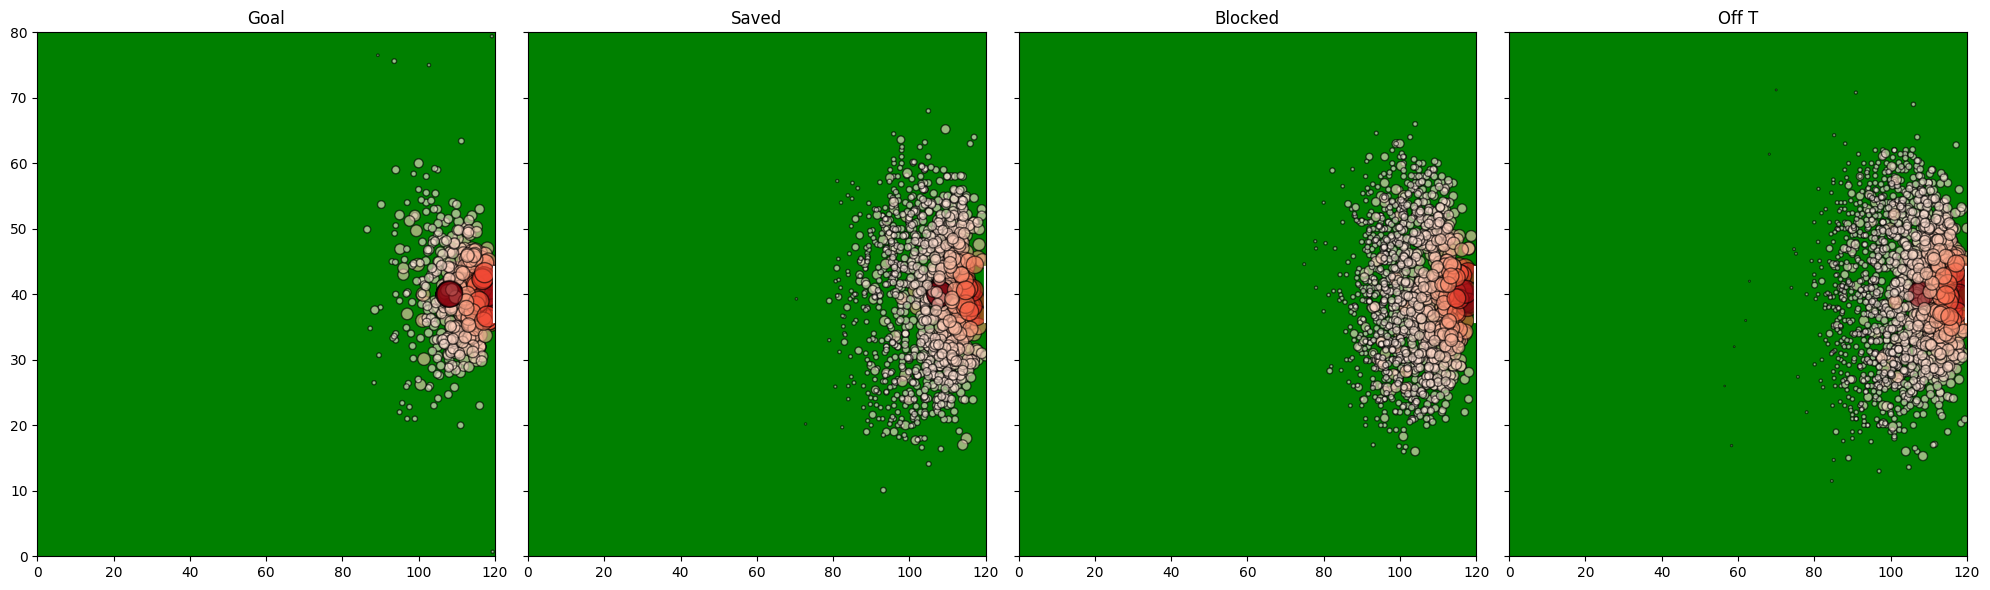

In [66]:
import seaborn as sns

outcomes = ["Goal","Saved","Blocked","Off T"]
fig, axes = plt.subplots(1, len(outcomes), figsize=(20,6), sharex=True, sharey=True)

for ax, outcome in zip(axes, outcomes):
    subset = df[df["shot_outcome_name"]==outcome]
    ax.set_xlim(0,120); ax.set_ylim(0,80)
    ax.set_facecolor("green")
    ax.plot([120,120],[36,44], color="white", linewidth=3)

    sc = ax.scatter(subset["x"], subset["y"],
                    c=subset["xG_model"], cmap="Reds",
                    s=subset["xG_model"]*500, alpha=0.6, edgecolor="black")
    ax.set_title(outcome)

plt.tight_layout()
plt.show()


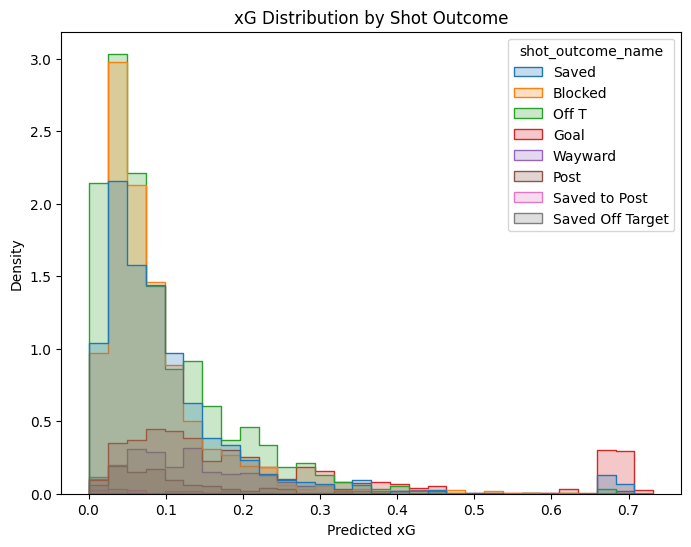

In [68]:
plt.figure(figsize=(8,6))
sns.histplot(data=df, x="xG_model", hue="shot_outcome_name",
             bins=30, kde=False, element="step", stat="density")
plt.xlabel("Predicted xG")
plt.ylabel("Density")
plt.title("xG Distribution by Shot Outcome")
plt.show()


In [69]:
total_shots = len(df)
goals = (df["shot_outcome_name"]=="Goal").sum()
xg_total = df["xG_model"].sum()
overperf = goals - xg_total

print(f"Shots: {total_shots}")
print(f"Goals: {goals}")
print(f"Total xG: {xg_total:.2f}")
print(f"Overperformance (Goals - xG): {overperf:.2f}")


Shots: 4900
Goals: 549
Total xG: 556.29
Overperformance (Goals - xG): -7.29
